In [1]:
# 首先设置显卡环境
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torchvision
import torchvision.transforms as transforms

import sys
sys.path.append("../")
import autoqnn

In [2]:
from autoqnn import datasets
# torchvision数据集的输出是在[0, 1]范围内的PILImage图片。
# 我们此处使用归一化的方法将其转化为Tensor，数据范围为[-1, 1]
# !wget -P /data/gongcheng/models/torch/weights/ https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# torch_weights_path="/data/gongcheng/models/torch/weights"
torch_weights_path=f"{os.environ['HOME']}/models/torch/weights"
data_root="~/datasets/cifar10"
dataset_name = 'cifar10'
trainloader,testloader,classes = datasets.cifar.get_cifar_dataloader(root=data_root,dataset=dataset_name)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from autoqnn.models.vgg import vgg7_64,vgg7_64_plane
from autoqnn.models.resnet import ResNet18, ResNet14

candidate_models = {
    'vgg7_64':vgg7_64(),
    'vgg7_64_plane':vgg7_64_plane(),
    'resnet14':ResNet14(),
    'resnet18':ResNet18()
}
model_name = 'resnet18' #'resnet14' #'vgg7_64_plane' #'vgg7_64'
model = candidate_models[model_name].cuda()
# model = ResNet14().cuda()
# model = ResNet18().cuda()
# model = vgg7_64().cuda()
# model = vgg7_64_plane().cuda()

In [4]:
# Optimizer and Criterition
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [5]:
import numpy as np
def adjust_learning_rate(optimizer, epoch, steps=[10]):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = optimizer.param_groups[0]['lr']
    if epoch in steps:
        lr=lr*0.1
    for param_group in optimizer.param_groups:       # 将更新的lr 送入优化器 optimizer 中，进行下一次优化
        param_group['lr'] = lr

epochs = 70
batch_time,data_time,loss,metrics = np.zeros(epochs,),np.zeros(epochs,),np.zeros(epochs,),np.zeros(epochs,)
val_loss,val_metrics=np.zeros(epochs,),np.zeros(epochs,)

for epoch in range(epochs):
    adjust_learning_rate(optim,epoch,steps=[30,60])
    print("##################################")
    print("lr=%.6f \n"%(optim.param_groups[0]['lr']))
    batch_time[epoch],data_time[epoch],loss[epoch],metric=autoqnn.core.train(trainloader,model,criterion,optim,
                       metric_meds=[autoqnn.core.top1],epoch=epoch)
    metrics[epoch]=metric[0].item()
    
    # print()
    val_loss[epoch],metric = autoqnn.core.validate(testloader,model,criterion,
                      metric_meds=[autoqnn.core.top1],
                      print_freq=100)
    val_metrics[epoch] = metric[0].item()

##################################
lr=0.100000 

Epoch: [0][100/100]	Time 0.094 (0.197)	Data 0.027 (0.101)	Loss 1.6132 (2.1606)	top1 39.000 (26.646)Test: [0/100]	Time 0.190 (0.190)	Loss 1.5985 (1.5985)	top1 45.000 (45.000)
 * top1 36.960
##################################
lr=0.100000 

Epoch: [1][100/100]	Time 0.091 (0.161)	Data 0.037 (0.102)	Loss 1.4541 (1.5305)	top1 46.400 (43.234)Test: [0/100]	Time 0.113 (0.113)	Loss 1.3810 (1.3810)	top1 46.000 (46.000)
 * top1 49.910
##################################
lr=0.100000 

Epoch: [2][100/100]	Time 0.093 (0.168)	Data 0.041 (0.108)	Loss 1.2671 (1.3184)	top1 52.400 (52.090)Test: [0/100]	Time 0.116 (0.116)	Loss 1.1588 (1.1588)	top1 56.000 (56.000)
 * top1 54.110
##################################
lr=0.100000 

Epoch: [3][100/100]	Time 0.093 (0.163)	Data 0.038 (0.119)	Loss 1.0674 (1.1400)	top1 62.000 (59.148)Test: [0/100]	Time 0.105 (0.105)	Loss 0.9030 (0.9030)	top1 72.000 (72.000)
 * top1 63.590
##################################
lr=0.100000 


In [6]:
val_total_loss,val_top1_acc = autoqnn.core.validate(testloader,model,criterion,
                      metric_meds=[autoqnn.core.top1],
                      print_freq=10)

Test: [0/100]	Time 0.108 (0.108)	Loss 0.3856 (0.3856)	top1 91.000 (91.000)
Test: [10/100]	Time 0.020 (0.023)	Loss 0.3579 (0.3576)	top1 91.000 (91.364)
Test: [20/100]	Time 0.020 (0.019)	Loss 0.4646 (0.3944)	top1 85.000 (90.857)
Test: [30/100]	Time 0.019 (0.018)	Loss 0.4862 (0.4247)	top1 90.000 (90.613)
Test: [40/100]	Time 0.019 (0.017)	Loss 0.4531 (0.4341)	top1 91.000 (90.683)
Test: [50/100]	Time 0.019 (0.017)	Loss 0.2220 (0.4263)	top1 93.000 (90.961)
Test: [60/100]	Time 0.019 (0.016)	Loss 0.2650 (0.4103)	top1 95.000 (91.049)
Test: [70/100]	Time 0.019 (0.016)	Loss 0.6437 (0.4071)	top1 91.000 (91.042)
Test: [80/100]	Time 0.019 (0.016)	Loss 0.2764 (0.4013)	top1 90.000 (90.963)
Test: [90/100]	Time 0.019 (0.016)	Loss 0.4382 (0.4004)	top1 91.000 (91.033)
 * top1 91.220


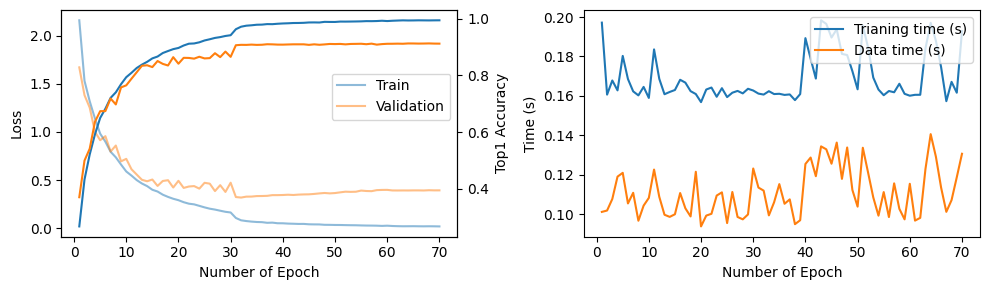

In [10]:
# Drawing the training and test losses
import matplotlib.pyplot as plt
# plt.style.use('')
fig = plt.figure(figsize=(10,3))
fig1 = plt.subplot(1,2,1)
# fig, ax1 = plt.subplots()
# ax1=fig.get_axisbelow()
ax1 = plt.gca()
X=np.arange(1,epochs+1)

ax1.plot(X, loss, alpha=0.5, label="Train")
ax1.plot(X, val_loss,  alpha=0.5, label="Validation")
ax1.set_xlabel("Number of Epoch")
ax1.set_ylabel("Loss")

ax2 = ax1.twinx()
ax2.plot(X, metrics/100, label="Train Top1")
ax2.plot(X, val_metrics/100, label="Val Top1")
ax2.set_ylabel("Top1 Accuracy")

fig1.legend(loc="upper right", bbox_to_anchor=(1, 0.75), bbox_transform=ax2.transAxes)

fig2 = plt.subplot(1,2,2)
# fig, ax1 = plt.subplots()
plt.plot(X,batch_time,label="Trianing time (s)")
plt.plot(X,data_time,label="Data time (s)")
plt.gca().set_xlabel("Number of Epoch")
plt.gca().set_ylabel("Time (s)")

fig2.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

In [8]:
# save the model weights and training infomation
import scipy.io as sio
def save_training_info_mat(file_name,info_dict):
    key = 'training_info'
    sio.savemat(file_name, {key: info_dict})
def loading_training_info_mat(file_name):
    key = 'training_info'
    # training_info
    mat_contents = sio.loadmat(file_name)
    # 打印字典内容
    keys = np.array(mat_contents[key].dtype.descr)[:,0]
    values = np.array([v.reshape(-1) for v in mat_contents[key][0,0]])
    return dict(zip(keys,values))
    
save_path = f"{torch_weights_path}/{model_name}"
save_weight_file = f"{save_path}/state_dict-loss-{val_total_loss:.2f}-top1-{val_top1_acc[0].item():.2f}.pth"
save_training_info_file = f"{save_path}/training_info-loss-{val_total_loss:.2f}-top1-{val_top1_acc[0].item():.2f}.mat"
training_info = {"batch_time":batch_time,
                 "data_time":data_time,
                 "loss":loss,
                 "metrics":metrics,
                 "val_loss":val_loss,
                 "val_metrics":val_metrics}
if not os.path.isdir(save_path):
    os.makedirs(save_path)
torch.save(model.state_dict(),save_weight_file)
# save training info
save_training_info_mat(save_training_info_file, training_info)
print(f"save to {save_path}")

save to /home/pytorchtest/models/torch/weights/resnet18


In [167]:
# loading weights and training info
loading_training_info = loading_training_info_mat(save_training_info_file)
model.load_state_dict(torch.load(save_weight_file))

<All keys matched successfully>

In [11]:
# 获取存储权值的格式信息
import os
import re

def get_info(folder_path,key='state_dict',verbose=True):
    # file_pattern = re.compile(f'{key}-loss-([\d.]+)-top1-([\d.]+).pth')
    # 定义文件夹路径
    # folder_path = "/home/pytorchtest/models/torch/weights/vgg7_64/"
    # 匹配文件名的正则表达式
    file_pattern = re.compile(r'state_dict-loss-([\d.]+)-top1-([\d.]+).pth')
    # file_pattern = re.compile(r'training_info-loss-([\d.]+)-top1-([\d.]+).mat')
    # 获取文件列表
    file_list = os.listdir(folder_path)
    # 存储结果的列表
    file_info_list = []
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            # 判断文件是否存在
            file_size = os.path.getsize(file_path)  # 获取文件大小（字节）
            # 从文件名中提取 loss 和 top1 参数
            match = file_pattern.match(file_name)
            if match:
                loss = float(match.group(1))
                top1 = float(match.group(2))
            else:
                continue
                loss = None
                top1 = None
            # 存储文件信息
            file_info_list.append({
                "文件路径": file_path,
                "文件大小": file_size,
                "Loss": loss,
                "Top1": top1
            })
    if verbose:
        # 格式化输出文件信息
        for file_info in file_info_list:
            print(f"文件路径: {file_info['文件路径']}")
            print(f"文件大小: {file_info['文件大小']/(2**20):.2f} 兆字节")
            print(f"Loss: {file_info['Loss']}")
            print(f"Top1: {file_info['Top1']}")
            print("-" * 30)
    return file_info_list

get_info(save_path,key="state_dict")

文件路径: /home/pytorchtest/models/torch/weights/resnet18/state_dict-loss-0.39-top1-91.22.pth
文件大小: 42.70 兆字节
Loss: 0.39
Top1: 91.22
------------------------------


[{'文件路径': '/home/pytorchtest/models/torch/weights/resnet18/state_dict-loss-0.39-top1-91.22.pth',
  '文件大小': 44777069,
  'Loss': 0.39,
  'Top1': 91.22}]

In [175]:
vgg7_64_plane_training_info = loading_training_info_mat("/home/pytorchtest/models/torch/weights/vgg7_64_plane/training_info-loss-0.39-top1-90.64.mat")
vgg7_64_training_info = loading_training_info_mat("/home/pytorchtest/models/torch/weights/vgg7_64/training_info-loss-0.40-top1-91.33.mat")

In [165]:
vgg7_64_training_info['batch_time'].mean(),vgg7_64_plane_training_info['batch_time'].mean()

(0.16600002203668868, 0.16853870776721414)